In [123]:
import json
import os, time
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from google.genai import types
from ratelimit import limits, sleep_and_retry

In [ ]:
MAX_CALLS_PER_MIN = 10

from google import genai
# api_key = ...
client = genai.Client(api_key=api_key)

In [3]:
json_folder = './captions'

In [4]:
file_path = './val_split_eng.parquet'
df = pq.read_table(file_path).to_pandas()

In [5]:
df

,image,sample_id,answer_key,type,grade,subject,language,chemical_structure,table,figure,graph
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1c6b887a-f86e-4982-acba-8438ec9a9878,D,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,b8761ea2-9fb7-4dd7-a39a-2bdf7d7218ca,A,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,c08221f8-a879-4a44-a109-36d4fd8b6e3d,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,c5d80e71-416e-46d4-b242-182653d66e6e,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8dbfe100-a068-4bac-bc3f-19681f7cea82,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
342,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,fac3196f-351b-405d-a528-cb25a9aeb5a0,C,text,[Grade: 11],Science,English,0.0,0.0,0.0,0.0
343,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7e04e851-7d8a-4bf2-861c-fde7845e61dc,C,text,[Grade: 11],Science,English,0.0,0.0,0.0,0.0
344,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,d82d4abc-4095-4aa3-9b23-009533dfaf4a,C,text,[Grade: 11],Science,English,0.0,0.0,0.0,0.0
345,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,198da32b-5732-4bc4-a560-79f54cb38146,A,text,[Grade: 11],Science,English,0.0,0.0,0.0,0.0


In [6]:
# histogram by subject
print(df['subject'].unique())
df['table'].value_counts()

['Biology' 'Chemistry' 'Physics' 'Science']


table
0.0    330
1.0      1
Name: count, dtype: int64

In [7]:
df[df['subject'] == 'Physics']

,image,sample_id,answer_key,type,grade,subject,language,chemical_structure,table,figure,graph
147,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0bd26208-1f9d-4e15-819e-c033648718f9,C,image_text,[Grade: 12],Physics,English,0.0,0.0,1.0,0.0
148,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,f3f1b6fa-833b-4b45-9810-88113df15874,D,image_text,[Grade: 12],Physics,English,0.0,0.0,1.0,0.0
149,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,91d59ff4-8751-4407-8f2f-824958439932,A,image_text,[Grade: 12],Physics,English,0.0,0.0,1.0,1.0
150,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,b9f57e89-9e98-43a7-9ff5-241ff4b4f01f,C,image_text,[Grade: 12],Physics,English,0.0,0.0,1.0,1.0
151,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,faabb1bd-408c-4300-aed6-508ee010e745,B,image_text,[Grade: 12],Physics,English,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
242,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,55c9ed69-6f6c-4896-8910-126e29a8b761,A,text,[Grade: 11],Physics,English,0.0,0.0,0.0,0.0
243,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3ceffa9b-5aed-47de-ae88-b4ec80b51881,D,text,[Grade: 11],Physics,English,0.0,0.0,0.0,0.0
244,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8f701e1c-320f-4d4f-9889-49d8afa25932,C,text,[Grade: 11],Physics,English,0.0,0.0,0.0,0.0
245,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4b7650c2-2d53-4ccc-83db-39abe9e68daf,A,text,[Grade: 11],Physics,English,0.0,0.0,0.0,0.0


In [ ]:
def load_captions(folder):
    captions = {}
    for filename in os.listdir(folder):
        if filename.endswith('.json'):
            file_path = os.path.join(folder, filename)
            with open(file_path, 'r') as f:
                data = json.load(f)
                # Assuming the JSON contains a 'caption' field
                captions[filename.split('.')[0]] = data.get('caption', '')
    return captions

In [10]:
# captions = load_captions(json_folder)

# # Add captions to the DataFrame
# df['caption'] = df['sample_id'].map(captions)

In [45]:
df.head(20)

,image,sample_id,answer_key,type,grade,subject,language,chemical_structure,table,figure,graph
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1c6b887a-f86e-4982-acba-8438ec9a9878,D,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,b8761ea2-9fb7-4dd7-a39a-2bdf7d7218ca,A,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,c08221f8-a879-4a44-a109-36d4fd8b6e3d,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,c5d80e71-416e-46d4-b242-182653d66e6e,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8dbfe100-a068-4bac-bc3f-19681f7cea82,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,0.0,1.0
5,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,60cd12cb-645a-474f-95d3-b51731d012b8,B,image_text,[Grade: 10-11],Biology,English,NaN,NaN,NaN,NaN
6,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,530dd6e1-1bb9-407b-8ff0-493ca5b4ad92,B,image_text,[Grade: 10-11],Biology,English,NaN,NaN,NaN,NaN
7,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,32aa2afc-f6d3-4a8d-8f44-97644bccbb67,A,image_text,[Grade: 10-11],Biology,English,NaN,NaN,NaN,NaN
8,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,9beb8630-64c1-498b-9455-2b11594b6bd3,A,image_text,[Grade: 10-11],Biology,English,NaN,NaN,NaN,NaN
9,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,62ef4dc3-2c92-44d6-bbf0-9880b3d71635,C,image_text,[Grade: 10-11],Biology,English,NaN,NaN,NaN,NaN


In [46]:
get_elements_contained(df.iloc[4]['chemical_structure'], df.iloc[4]['table'], df.iloc[4]['figure'], df.iloc[4]['graph'])

'graph'

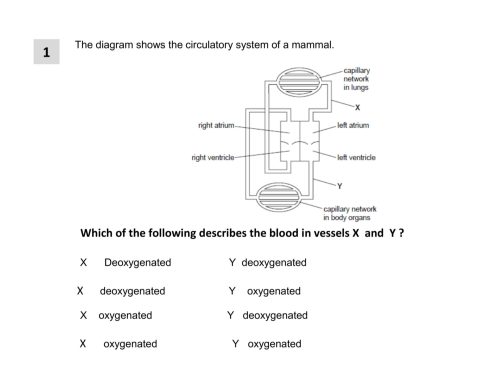

In [22]:
visualize_image(df['image'][0]['bytes'])

In [ ]:
# print(df['caption'][511])

# df['table'].isnull().sum()

In [ ]:
prompt_template = (
    """You are a sophisticated Vision-Language Model (VLM) capable of analyzing images containing multiple-choice questions. 
    To guide your analysis, you may adopt the following process:
    0. Consider the subject of question is {subject} and image contains {content}.
    1. Image Analysis: Examine the image closely, identifying key elements such as text, diagrams, and any other relevant features.
    2. Question Text Extraction: Extract the text of the question
    3. Extract Answer Choices: Identify and extract the answer choices provided in the image 
        - if the answer options are not enumerated with letters, do enumerate them with letters (A, B, C, D, ...)
    4. Look for additional visual elements such as tables, diagrams, charts, or graphs.
    5. Ensure to consider any multilingual or multidomain aspects of the image, including text in different languages or mathematical/physics/scientific notation.
    6. Analyze the complete context and data provided
    7. Select correct answer based solely on analysis. 
    8. Respond by only the corresponding letter (single capital letter) without any extra explanation.
    9. If the answer is not clear, still provide the best guess based on the analysis. 
    """
)

prompt_template_stricter = (
    """You are a sophisticated Vision-Language Model (VLM) capable of analyzing images containing multiple-choice questions. 
    To guide your analysis, you may adopt the following process:
    0. Consider the subject of question is {subject} and image contains {content}.
    1. Image Analysis: Examine the image closely, identifying key elements such as text, diagrams, and any other relevant features.
    2. Question Text Extraction: Extract the text of the question
    3. Extract Answer Choices: Identify and extract the answer choices provided in the image 
        - if the answer options are not enumerated with letters, do enumerate them with letters (A, B, C, D, ...)
    4. Look for additional visual elements such as tables, diagrams, charts, or graphs.
    5. Ensure to consider any multilingual or multidomain aspects of the image, including text in different languages or mathematical/physics/scientific notation.
    6. Analyze the complete context and data provided
    7. Select correct answer based solely on analysis. 
    8. Respond by only the corresponding letter (single capital letter) without any extra explanation.
    9. If the answer is not clear, still provide the best guess as single capital letter. 

    Always respond with a single capital letter (A, B, C, D, E) without any extra explanation. 
    """
)

prompt_classification = """
Take following text and classify it into one of the following categories based on final answer:
A, B, C, D, E
Respond with only the letter of the classification and nothing else.
"""

In [ ]:
def visualize_image(bytes_image):
    image = Image.open(BytesIO(bytes_image))
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    
def get_elements_contained(chem_struct, table, figure, graph):
    # Create a list to store the elements
    elements = []
    if chem_struct == 1:
        elements.append('chemical structure')
    if table == 1:
        elements.append('table')
    if figure == 1:
        elements.append('figure')
    if graph == 1:
        elements.append('graph')
    
    return ", ".join(elements)
    
def prepare_content(df_row, prompt_template):
    # Extract the relevant fields from the DataFrame row
    subject = df_row['subject']
    content = get_elements_contained(df_row['chemical_structure'], 
                                     df_row['table'], 
                                     df_row['figure'], 
                                     df_row['graph'])

    prompt = prompt_template.format(
        subject=subject,
        content=content
    )
    image = Image.open(BytesIO(df_row['image']['bytes']))
    
    return prompt, image

def classify_answer(answer):
    # Define the categories
    categories = ['A', 'B', 'C', 'D', 'E']
    
    # Check if the answer is in the categories
    if answer in categories:
        return answer
    else:
        try:
            # Attempt to classify the answer using the model
            response = client.models.generate_content(
                model="gemini-2.0-flash",
                contents=[prompt_classification, answer],
            )
            time.sleep(1)
            return response.text.strip()
        except Exception as e:
            print(f"Error classifying answer: {e}")
            # Fallback to a default classification if an error occurs
            # You can choose to return None or a default category
            # Here, we return 'Unknown' as a placeholder
            return answer


def get_answer(df_row, model, prompt_template, thinking=True):
    prompt, image = prepare_content(df_row, prompt_template)

    try:    
        response = client.models.generate_content(
            model=model,
            contents=[prompt, image],
            config=types.GenerateContentConfig(
                thinking_config=types.ThinkingConfig(thinking_budget=1024)
            ),
        ) if thinking else client.models.generate_content(
            model=model,
            contents=[prompt, image],
        )
    except Exception as e:
        print(f"Error generating content: {e}")
        return None
    
    answer = {'id': df_row['sample_id'], 
              'answer_key': response.text, 
              'language': df_row['language']}
    return answer


@sleep_and_retry
# @limits(calls=MAX_CALLS_PER_MIN, period=80)
def get_answers(df, model, prompt_template, start=0, end=None, thinking=True, attempts=3):
    if end is None:
        end = len(df)
    if start >= end:
        return []

    answers = []
    problematic_rows = []
    for i in range(start, end):
            answer = get_answer(df.iloc[i], model, prompt_template, thinking=thinking)
            cnt = 1
            while answer is None and cnt < attempts:
                print(f"Retrying {i}...")
                time.sleep(3)
                answer = get_answer(df.iloc[i], model, prompt_template, thinking=thinking)
                cnt += 1
            if answer is None:
                print(f"Failed to get answer for row {i} after {attempts} attempts.")
                problematic_rows.append(i)
            else: 
                answers.append(answer)
                time.sleep(1)
            
    return answers, problematic_rows

def get_answers_chuncked(df, model, prompt_template, step=10, thinking=True):
    answers = []
    problematic_rows = []
    for i in range(0, len(df), step):
        end = min(i + step, len(df))
        try:
            print(f"Processing rows {i}-{end}")
            chunk_answers, problematic_rows = get_answers(df, model, prompt_template, 
                                                          start=i, end=end, thinking=thinking)
            answers.extend(chunk_answers)
            problematic_rows.extend(problematic_rows)
            time.sleep(10)
        except Exception as e:
            print(f"Error processing chunk {i}-{end}: {e}")

    return answers, problematic_rows

# @sleep_and_retry
# @limits(calls=10, period=60)
def postprocess_answes(answers, beginning=0, end=None):
    if end is None:
        end = len(answers)
    if beginning >= end:
        return []
    for row in answers:
        row['answer_key'] = classify_answer(row['answer_key'])

def make_gold_file_json(df, path):
    gold_file_data = []

    for index, row in df.iterrows():
        sample_id = row['sample_id']
        answer_key = row['answer_key']
        language = row['language']

        gold_file_data.append({
            'id': sample_id,
            'answer_key': answer_key,
            'language': language
        })

    with open(path, 'w') as json_file:
        json.dump(gold_file_data, json_file, indent=4)
    print(f"JSON file {path} created successfully.")

def save_answers_to_json(answers, filename):
    with open(filename, 'w') as json_file:
        json.dump(answers, json_file, indent=4)

    print(f"JSON file {filename} created successfully.")

In [ ]:
# prompt, image = prepare_content(df.iloc[0])
# response = client.models.generate_content(
#     model="gemini-2.0-flash", contents=["What is on the image and what conclusions can be drawn from it?", image],
# )
# print(response.text)

# Convert the bytes object to an Image instance

# image = Image.open(BytesIO(df['image'][0]['bytes']))
# plt.imshow(image)

# response = client.models.generate_content(
#     model="gemini-2.5-flash-preview-04-17",
#     contents=[prompt, image],
#     config=types.GenerateContentConfig(
#         thinking_config=types.ThinkingConfig(thinking_budget=1024)
#     ),
# )

# print(response.text)

#i = 2
# for i in range(0, 5):
#     print(answers[i]['answer_key']) 
#     print("classification: ", classify_answer(answers[i]['answer_key']), end="\n\n")

#postprocess_answes(answers)
# answers
# get_answer(df.iloc[0], "gemini-2.5-flash-preview-04-17")


# answers = []
# for i in range(10):
#     try:
#         answer = get_answer(df.iloc[i], "gemini-2.5-flash-preview-04-17")
#         answers.append(answer)
#     except Exception as e:
#         print(f"Error processing row {i}: {e}")
# print(answers)

# answers = get_answers(df, "gemini-2.0-flash", 
#                       prompt_template=prompt_template_shorter, 
#                       start=0, end=len(df), thinking=False)


    

In [272]:
print(len(answers))

347


In [ ]:
answers_gemini_2flash = get_answers_chuncked(df, "gemini-2.0-flash",
                                             prompt_template=prompt_template_stricter, 
                                             step=10, thinking=False)

Processing rows 0-10
Processing rows 10-20
Processing rows 20-30
Processing rows 30-40
Processing rows 40-50
Processing rows 50-60
Processing rows 60-70
Processing rows 70-80
Processing rows 80-90
Processing rows 90-100
Processing rows 100-110
Error processing row 109: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.0-flash', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https:/

In [ ]:
print(len(ans for ans answers_gemini_2flash if ans['answer_key'] not in ['A', 'B', 'C', 'D', 'E']))

In [ ]:
postprocess_answers(answers_gemini_2flash, beginning=0, end=len(answers_gemini_2flash))

In [ ]:
answers = []

In [235]:
# start = 334 
start = 108
# end = len(df)
end = 110
step = 2
for begin in range(start, end, step):
    end_range = min(begin + step, end)
    print(f"Processing rows {begin} to {end_range}")
    answers_curr = get_answers(df, "gemini-2.0-flash", 
                               prompt_template=prompt_template_stricter, 
                               start=begin, end=end_range, thinking=False)
    answers.extend(answers_curr)
    print(f"Processed {len(answers_curr)} answers.")
    time.sleep(10)  # Sleep for 60 seconds after each batch

Processing rows 108 to 110
Processed 2 answers.


In [249]:
len(answers)

347

In [247]:
postprocess_answes(answers)

Error classifying answer: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.0-flash', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '4s'}]}}
Error classifying answer: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, 

In [268]:
# start = 10
# end = len(answers)
# step = 20

# for begin in range(start, end, step):
#     end_range = min(begin + step, end)
#     print(f"Processing rows {begin} to {end_range}")
#     postprocess_answes(answers, beginning=begin, end=end_range)
#     print(f"Processed {len(answers[begin:end_range])} answers.")
#     time.sleep(10)  # Sleep for 60 seconds after each batch

In [269]:
# answers[120:]

In [270]:
with open('answers_2_flash.json', 'w') as json_file:
    json.dump(answers, json_file, indent=4)

print("JSON file 'answers.json' created successfully.")

JSON file 'answers.json' created successfully.


In [83]:
ind, row = next(df.iterrows())

In [86]:
row['sample_id']

'1c6b887a-f86e-4982-acba-8438ec9a9878'

In [93]:
make_gold_file_json(df)

JSON file 'gold_file.json' created successfully.


In [133]:
make_gold_file_json(df.iloc[0:334], 'gold_file_limited_334.json')

JSON file gold_file_limited_334.json created successfully.


In [92]:
df

,image,sample_id,answer_key,type,grade,subject,language,chemical_structure,table,figure,graph
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1c6b887a-f86e-4982-acba-8438ec9a9878,D,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,b8761ea2-9fb7-4dd7-a39a-2bdf7d7218ca,A,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,c08221f8-a879-4a44-a109-36d4fd8b6e3d,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,c5d80e71-416e-46d4-b242-182653d66e6e,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,1.0,0.0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8dbfe100-a068-4bac-bc3f-19681f7cea82,C,image_text,[Grade: 10-11],Biology,English,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
342,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,fac3196f-351b-405d-a528-cb25a9aeb5a0,C,text,[Grade: 11],Science,English,0.0,0.0,0.0,0.0
343,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7e04e851-7d8a-4bf2-861c-fde7845e61dc,C,text,[Grade: 11],Science,English,0.0,0.0,0.0,0.0
344,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,d82d4abc-4095-4aa3-9b23-009533dfaf4a,C,text,[Grade: 11],Science,English,0.0,0.0,0.0,0.0
345,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,198da32b-5732-4bc4-a560-79f54cb38146,A,text,[Grade: 11],Science,English,0.0,0.0,0.0,0.0
